# Phase 3 — Modeling, Evaluation & Calibration

**Goal:** Train candidate models, pick a winner, calibrate probabilities, and save a deployable bundle.

**Inputs:** Phase-2 modeling table (`ml_table.parquet`/CSV).

**Outputs (example):**
- `models/phase3_bundle.joblib`
- `reports/bundle_meta_{timestamp}.json`  (thresholds, winner info)

**Assumptions:**
- Label column is `viral` (0/1).
- All model code and custom classes like `SoftVotingEnsemble` are importable at load time.


In [104]:
# ===== 1) SETUP =====

# --- Standard library ---
import os
import glob
import json
from pathlib import Path
from datetime import datetime, timezone

# --- Third-party ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import scipy.sparse as sp

# --- ML: scikit-learn ---
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline  # (Use this; no need for an alias + duplicate imports)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    roc_auc_score,
    brier_score_loss,
    confusion_matrix,
    classification_report,
)

# --- ML: gradient boosting libs ---
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# --- Local models ---
from models.soft_voting_ensemble import SoftVotingEnsemble


In [105]:
# ===== 2) CONFIG  =====

# reproducibility
RANDOM_STATE = 42

# operating point (matches your "viral = top 10%" definition)
TOP_FRAC = 0.10

# TF-IDF sizes 
TITLE_TFIDF_MAX_FEATURES = 30000
DESC_TFIDF_MAX_FEATURES  = 40000
TAGS_TFIDF_MAX_FEATURES  = 15000

# n-grams
TITLE_TFIDF_NGRAM = (1,2)
DESC_TFIDF_NGRAM  = (1,2)

print("Configured TOP_FRAC:", TOP_FRAC)

Configured TOP_FRAC: 0.1


In [106]:
# ===== 3) PATH SETUP AND INPUT AUTODISCOVERY  =====

def find_repo_root(start: Path = Path.cwd(), must_have=("data",)):
    """Walk upward until we find a folder that contains the required entries (e.g., 'data')."""
    p = start
    while True:
        if all((p / m).exists() for m in must_have):
            return p
        if p.parent == p:
            raise FileNotFoundError(f"Could not find a repo root above {start} containing: {must_have}")
        p = p.parent

# normalize CWD to repo root so all relative paths are 'repo/'
REPO_ROOT = find_repo_root(Path.cwd(), must_have=("data",))
os.chdir(REPO_ROOT)
print("Repo root:", REPO_ROOT)
print("CWD set to:", Path.cwd())

# locate newest Phase-2 table
DATA_DIR = REPO_ROOT / "data" / "processed"
cands = list(DATA_DIR.glob("ml_table_*.parquet"))
assert cands, f"No files matching ml_table_*.parquet under {DATA_DIR}. (Did you run Phase 2?)"
INPUT_PATH = str(max(cands, key=lambda p: p.stat().st_mtime).resolve())
print("Using INPUT_PATH:", INPUT_PATH)

# standard output dirs under repo root (avoid notebooks/)
MODELS_DIR  = str((REPO_ROOT / "models").resolve())
REPORTS_DIR = str((REPO_ROOT / "reports").resolve())
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)
print("Models dir:", MODELS_DIR)
print("Reports dir:", REPORTS_DIR)

Repo root: /Users/asmitabisht/Desktop/repo
CWD set to: /Users/asmitabisht/Desktop/repo
Using INPUT_PATH: /Users/asmitabisht/Desktop/repo/data/processed/ml_table_2025-09-22T03-12-02Z.parquet
Models dir: /Users/asmitabisht/Desktop/repo/models
Reports dir: /Users/asmitabisht/Desktop/repo/reports


In [109]:
# ===== 4) DATA LOAD AND TARGET CHECK  =====

def _load_df(path: str) -> pd.DataFrame:
    p = Path(path)
    if p.suffix.lower() == ".parquet":
        return pd.read_parquet(p)
    elif p.suffix.lower() == ".csv":
        return pd.read_csv(p)

df = _load_df(INPUT_PATH)
print(f"Loaded: {INPUT_PATH}")
print(f"Rows: {len(df):,} | Cols: {len(df.columns)}")
print("Sample columns:", list(df.columns)[:20])

print("Positive rate (overall):", round(float(df["viral"].mean()), 3))


Loaded: /Users/asmitabisht/Desktop/repo/data/processed/ml_table_2025-09-22T03-12-02Z.parquet
Rows: 5,240 | Cols: 35
Sample columns: ['videoId', 'channelId', 'categoryId', 'publishedAt_utc', 'upload_day', 'duration_log1p', 'tags_count', 'title_len_words', 'title_len_chars', 'title_caps_ratio', 'title_num_exclaim', 'title_num_question', 'desc_len_words', 'pub_hour', 'pub_dow', 'channel_subscriberCount_log1p', 'channel_viewCount_log1p', 'channel_videoCount_log1p', 'title_has_question', 'title_has_exclaim']
Positive rate (overall): 0.132


In [110]:
# ===== 5) LOAD + NORMALIZE TEXT  =====

def find_latest_phase2_parquet(phase2_dir: str):
    pats = [
        os.path.join(phase2_dir, "ml_table_*.parquet"),
        os.path.join("data/processed", "phase2_latest.parquet"),  # optional symlink
    ]
    cand = []
    for pat in pats:
        cand.extend(glob.glob(pat))
    if not cand:
        return None
    cand.sort(key=lambda p: os.path.getmtime(p), reverse=True)
    return cand[0]

# resolve the path
if INPUT_PATH is None:
    INPUT_PATH = find_latest_phase2_parquet(PHASE2_DIR)

assert INPUT_PATH is not None, "No Phase-2 parquet found. Set INPUT_PATH or put files in data/processed/phase2_prototype/."
p = Path(INPUT_PATH); assert p.exists(), f"Input not found: {p}"

# load file
if p.suffix.lower() == ".parquet":
    df = pd.read_parquet(p)
elif p.suffix.lower() == ".csv":
    df = pd.read_csv(p)
else:
    raise ValueError("INPUT_PATH must be .parquet or .csv")

print("Loaded:", p)
print("Rows:", len(df), "| Cols:", len(df.columns))
print("Sample columns:", list(df.columns)[:20])
assert 'viral' in df.columns, "Phase-2 table must include a 'viral' column."
print("Positive rate (overall):", round(df['viral'].mean(), 3))

# titles / descriptions
for col in ['title', 'description']:
    if col not in df.columns:
        df[col] = ''
    df[col] = df[col].fillna('').astype(str)

# build/repair tags_text from any available source; override if empty/no_tags-only ---

def tags_to_text_any(x):
    if pd.isna(x):
        return ''
    if isinstance(x, (list, tuple)):
        toks = [str(t).strip() for t in x if str(t).strip()]
        return ' '.join(toks)
    s = str(x).strip()
    # JSON list stored as string?
    if s.startswith('[') and s.endswith(']'):
        try:
            arr = json.loads(s)
            if isinstance(arr, list):
                toks = [str(t).strip() for t in arr if str(t).strip()]
                return ' '.join(toks)
        except Exception:
            pass
    # fallback: split on commas/whitespace
    s = re.sub(r'[\r\n\t]+', ' ', s)
    toks = [t.strip() for t in re.split(r'[,\s]+', s) if t.strip()]
    return ' '.join(toks)

# if tags_text exists, keep it only if it has any real content
has_tags_text = 'tags_text' in df.columns
if has_tags_text:
    df['tags_text'] = df['tags_text'].fillna('').astype(str).str.strip()
    has_real_in_existing = (df['tags_text'].ne('no_tags') & df['tags_text'].ne('')).any()
else:
    df['tags_text'] = ''
    has_real_in_existing = False

# if not real, try to rebuild from raw cols 
if not has_real_in_existing:
    rebuilt = False
    for cand in ['tags_str', 'tags', 'tags_json']:
        if cand in df.columns:
            df['tags_text'] = df[cand].apply(tags_to_text_any)
            rebuilt = True
            break
    if not rebuilt:
        # nothing available; will fall back to 'no_tags'
        pass

# final clean + placeholder and numeric flags
df['tags_text'] = df['tags_text'].fillna('').astype(str).str.strip()
df.loc[df['tags_text'] == '', 'tags_text'] = 'no_tags'

#  presence/quality flags 
df['title_missing'] = (df['title'].str.strip() == '').astype(int)
df['description_missing'] = (df['description'].str.strip() == '').astype(int)
df['has_tags'] = (df['tags_text'] != 'no_tags').astype(int)
df['tags_count'] = df['tags_text'].str.count(r'\S+')

print("Ready text/flags: title, description, tags_text, title_missing, description_missing, has_tags")
print("Rows with real tags (not 'no_tags'):", int((df['tags_text'] != 'no_tags').sum()))
print("Sample tags_text:", df['tags_text'].head(10).tolist())


Loaded: /Users/asmitabisht/Desktop/repo/data/processed/ml_table_2025-09-22T03-12-02Z.parquet
Rows: 5240 | Cols: 35
Sample columns: ['videoId', 'channelId', 'categoryId', 'publishedAt_utc', 'upload_day', 'duration_log1p', 'tags_count', 'title_len_words', 'title_len_chars', 'title_caps_ratio', 'title_num_exclaim', 'title_num_question', 'desc_len_words', 'pub_hour', 'pub_dow', 'channel_subscriberCount_log1p', 'channel_viewCount_log1p', 'channel_videoCount_log1p', 'title_has_question', 'title_has_exclaim']
Positive rate (overall): 0.132
Ready text/flags: title, description, tags_text, title_missing, description_missing, has_tags
Rows with real tags (not 'no_tags'): 3832
Sample tags_text: ['no_tags', 'no_tags', '#ps5live death_stranding_2:_on_the_beach death_stranded_two. playstation_5 sony_interactive_entertainment', 'no_tags', 'a_for_apple abc abcd alphabet baby_rhymes baby_videos cartoon cha_chha_ja_jha cham cham_cham chhamchhamkidstv education for_kids hindi_alphabet hindi_balgeet hindi

In [112]:
# ===== 6) FEATURE SELECTION & STRATIFIED TRAIN/VAL/TEST SPLIT =====

num_cols = [
    'duration_log1p','tags_count','title_len_words','title_len_chars','title_caps_ratio',
    'title_num_exclaim','title_num_question','desc_len_words','pub_hour','pub_dow',
    'channel_subscriberCount_log1p','channel_viewCount_log1p','channel_videoCount_log1p',
    'title_missing','description_missing','has_tags','title_has_question','title_has_exclaim',
    'title_emoji_count','desc_emoji_count',
    'pub_hour_sin','pub_hour_cos' # features from phase 2
]
cat_cols  = ['categoryId']
text_cols = ['title','description','tags_text']

use_cols = [c for c in (num_cols + cat_cols + text_cols) if c in df.columns]
missing = sorted(set(num_cols + cat_cols + text_cols) - set(use_cols))
if missing:
    print("NOTE: missing expected cols (skipping):", missing)

X = df[use_cols].copy()
y = df['viral'].astype(int).values

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, random_state=RANDOM_STATE, stratify=y_temp
)

print(f"Train {len(X_train)} | Val {len(X_val)} | Test {len(X_test)}")
print("Pos rate:", round(y_train.mean(),3), round(y_val.mean(),3), round(y_test.mean(),3))


Train 3668 | Val 524 | Test 1048
Pos rate: 0.132 0.132 0.132


In [117]:
# ===== 7) BUILD & AUDIT PREPROCESSING PIPLINE =====

if 'tags_text' in X_train.columns:
    X_train.loc[:, 'tags_text'] = (
        X_train['tags_text'].fillna('').astype(str).str.strip().replace('', 'no_tags')
    )

# Adaptive min_df to avoid "empty vocabulary" on small datasets
N = max(1, len(X_train))
TITLE_TFIDF_MAX_FEATURES = globals().get('TITLE_TFIDF_MAX_FEATURES', 30000)
DESC_TFIDF_MAX_FEATURES  = globals().get('DESC_TFIDF_MAX_FEATURES',  40000)
TAGS_TFIDF_MAX_FEATURES  = globals().get('TAGS_TFIDF_MAX_FEATURES',  15000)
TITLE_TFIDF_NGRAM = globals().get('TITLE_TFIDF_NGRAM', (1,2))
DESC_TFIDF_NGRAM  = globals().get('DESC_TFIDF_NGRAM',  (1,2))
TITLE_TFIDF_MIN_DF = max(1, int(0.001 * N))
DESC_TFIDF_MIN_DF  = max(1, int(0.002 * N))
TAGS_TFIDF_MIN_DF  = 1

def _has_nonempty_text(colname: str) -> bool:
    if colname not in X_train.columns:
        return False
    s = X_train[colname].astype(str).fillna('')
    nonempty = (s.str.replace(r'\W+',' ', regex=True).str.strip().str.len() > 0).sum()
    return nonempty > 0

# numeric / categorical
num_exist = [c for c in num_cols if c in X.columns]
cat_exist = [c for c in cat_cols if c in X.columns]

num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('scaler',  StandardScaler(with_mean=False))]) if num_exist else None
cat_pipe = OneHotEncoder(handle_unknown='ignore') if cat_exist else None

transformers = []
if num_pipe is not None: transformers.append(('num', num_pipe, num_exist))
if cat_pipe is not None: transformers.append(('cat', cat_pipe, cat_exist))

# title TF-IDF
if _has_nonempty_text('title'):
    transformers.append(('title', TfidfVectorizer(
        max_features=TITLE_TFIDF_MAX_FEATURES, ngram_range=TITLE_TFIDF_NGRAM,
        min_df=TITLE_TFIDF_MIN_DF, stop_words='english', sublinear_tf=True, strip_accents='unicode'
    ), 'title'))
else:
    print("SKIP title TF-IDF: no non-empty docs in train")

# description TF-IDF
if _has_nonempty_text('description'):
    transformers.append(('desc', TfidfVectorizer(
        max_features=DESC_TFIDF_MAX_FEATURES, ngram_range=DESC_TFIDF_NGRAM,
        min_df=DESC_TFIDF_MIN_DF, stop_words='english', sublinear_tf=True, strip_accents='unicode'
    ), 'description'))
else:
    print("SKIP description TF-IDF: no non-empty docs in train")

# tags TF-IDF (force include; normalized empties to 'no_tags')
transformers.append(('tags', TfidfVectorizer(
    max_features=TAGS_TFIDF_MAX_FEATURES,
    min_df=1,                  # don't prune on small folds
    lowercase=True,
    sublinear_tf=True,
    token_pattern=r'[^,\s]+',  # split on commas/whitespace
    stop_words=None,
    binary=True                # presence/absence
), 'tags_text'))


# add char-ngrams to boost precision on punctuation/emojis
if 'title' in X.columns and _has_nonempty_text('title'):
    transformers.append(('title_char', TfidfVectorizer(
        analyzer='char', ngram_range=(3,5), min_df=5, max_features=30000, sublinear_tf=True
    ), 'title'))
if 'description' in X.columns and _has_nonempty_text('description'):
    transformers.append(('desc_char', TfidfVectorizer(
        analyzer='char', ngram_range=(3,5), min_df=5, max_features=40000, sublinear_tf=True
    ), 'description'))

pre = ColumnTransformer(transformers, remainder='drop', sparse_threshold=1.0)
print("`pre` is ready with", len(transformers), "transformers.")


def transformer_summary(pre):
    names = []
    sizes = []
    try:
        fn = pre.get_feature_names_out()
        names = list(fn)
        sizes = None
    except Exception:
        # fall back: estimate by sub-transformers
        for name, trans, cols in pre.transformers_:
            if name == 'remainder':
                continue
            if hasattr(trans, 'get_feature_names_out'):
                try:
                    k = len(trans.get_feature_names_out(cols if isinstance(cols, list) else None))
                except:
                    k = -1
            elif hasattr(trans, 'categories_'):  # OneHotEncoder
                k = sum(len(c) for c in trans.categories_)
            else:
                k = len(cols) if hasattr(cols, '__len__') else -1
            print(f"{name:12s} -> {k} features from {cols}")
        return

    # if names are flattened, also show per-block counts
    print(f"Total transformed features: {len(names)}")
    for name, trans, cols in pre.transformers_:
        if name == 'remainder':
            continue
        mask = [n.startswith(name + "__") for n in names]
        print(f"{name:12s} -> {int(np.sum(mask))} features from {cols}")

pre_fitted = pre.fit(X_train, y_train) 
transformer_summary(pre_fitted)





`pre` is ready with 7 transformers.
Total transformed features: 92578
num          -> 22 features from ['duration_log1p', 'tags_count', 'title_len_words', 'title_len_chars', 'title_caps_ratio', 'title_num_exclaim', 'title_num_question', 'desc_len_words', 'pub_hour', 'pub_dow', 'channel_subscriberCount_log1p', 'channel_viewCount_log1p', 'channel_videoCount_log1p', 'title_missing', 'description_missing', 'has_tags', 'title_has_question', 'title_has_exclaim', 'title_emoji_count', 'desc_emoji_count', 'pub_hour_sin', 'pub_hour_cos']
cat          -> 16 features from ['categoryId']
title        -> 3071 features from title
desc         -> 9427 features from description
tags         -> 15000 features from tags_text
title_char   -> 25042 features from title
desc_char    -> 40000 features from description


In [119]:
# ===== 8) TAG FIELD SANITY CHECKS (COUNTS + SAMPLES) =====

# how many rows with actual tags (not 'no_tags')?
print("ALL data, has real tags:", (df['tags_text'] != 'no_tags').sum())
print("TRAIN,   has real tags:", (X_train['tags_text'] != 'no_tags').sum())

# peek a few examples from TRAIN that have real tags (out of curiosity)
print(X_train.loc[X_train['tags_text']!='no_tags', 'tags_text'].head(10).tolist())

print("tags_text in X_train? ->", 'tags_text' in X_train.columns)
if 'tags_text' in X_train.columns:
    print("Non-empty tags_text rows in TRAIN:", (X_train['tags_text'].astype(str).str.strip() != '').sum())
    print("Sample tags_text values:", X_train['tags_text'].head(5).tolist())

print("text_cols:", text_cols)
print("X_train columns sample:", list(X_train.columns)[:30])


ALL data, has real tags: 3832
TRAIN,   has real tags: 2683
['politics_monday political_analysis politics news politics_news charlie_kirk charlie_kirk_assassination charlie_kirk_murder utah_valley free_speach right_wing_media cancel_culture jd_vance trump trump_administration charlie_kirk_celebration mourning_charlie_kirk pbs pbs_news', 'abc abc_songs learning_songs phonic_songs nursery rehymes kids_songs a_for_apple abcd kids_song learningsong phonic_song abcdefg b_for_baloon abc_learning_songs pre_school preschool_songs nurseryrhymes\u200b musicforkids\u200b childrensmusic\u200b abcdsong', 'yo_soy_aranza aranza aranza_merlin merlin team conny emma prima bromas la_espio hermana mama papa familia yadeli respeto bris_merlin michelle_merlin michi patita', 'imperador_da_nação_react reações_dos_rivais reações_dos_rivais_-_fla_2_(6x5)_2_barcelona reacoes_mengo_2x2_barcelona vamos_rir_barcelona_2_(5x6)_2_flamengo react_do_rival imprensa_carioca_flamengo imprensa_espanhola midia_esportiva_paul

In [ ]:
# ===== 9) FIT PREPROCESSOR ON TRAIN, TRANSFORM SPLITS, CACHE ARTIFACT =====
# create the models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

pre_fitted = pre.fit(X_train, y_train)        # pre was defined in your preprocessor cell
Xt_train = pre_fitted.transform(X_train)
Xt_val   = pre_fitted.transform(X_val)
Xt_test  = pre_fitted.transform(X_test)

print("Shapes:", Xt_train.shape, Xt_val.shape, Xt_test.shape)
print("Sparse?", sparse.issparse(Xt_train), sparse.issparse(Xt_val), sparse.issparse(Xt_test))

# save to reuse later without refitting
joblib.dump(pre_fitted, "models/preprocess_phase3.joblib")

Shapes: (3668, 92578) (524, 92578) (1048, 92578)
Sparse? True True True


['models/preprocess_phase3.joblib']

In [ ]:
# ===== 10) DIMENSIONALITY REDUCTION FOR TREE MODELS (TruncatedSVD) =====
svd_components = 200  # 200–400 typical
svd = TruncatedSVD(n_components=svd_components, n_iter=7, random_state=42)  

Xt_train_svd = svd.fit_transform(Xt_train)
Xt_val_svd   = svd.transform(Xt_val)
Xt_test_svd  = svd.transform(Xt_test)

# clean any tiny NaNs/Infs if upstream had degenerate terms
for M in (Xt_train_svd, Xt_val_svd, Xt_test_svd):
    np.nan_to_num(M, copy=False, posinf=1e6, neginf=-1e6)


/Users/asmitabisht/Desktop/repo/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/asmitabisht/Desktop/repo/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/asmitabisht/Desktop/repo/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


In [123]:
# ===== ADDITIONAL HELPERS FOR MODELS =====
def summarize_probs(name, p_val, p_test, y_val, y_test):
    k = max(1, int(len(p_val) * TOP_FRAC))
    thr = np.partition(p_val, -k)[-k]
    pred_top = (p_test >= thr).astype(int)

    pr_auc  = average_precision_score(y_test, p_test)
    roc_auc = roc_auc_score(y_test, p_test)
    brier   = brier_score_loss(y_test, p_test)
    prec    = precision_score(y_test, pred_top)
    rec     = recall_score(y_test, pred_top)
    base    = y_test.mean()
    lift    = prec / base if base > 0 else float('nan')

    print(f"[{name}] PR-AUC={pr_auc:.4f}  ROC-AUC={roc_auc:.4f}  Brier={brier:.4f}")
    print(f"[{name}] thr(val top {int(TOP_FRAC*100)}%)={thr:.4f}  precision@{int(TOP_FRAC*100)}%={prec:.3f}  recall@{int(TOP_FRAC*100)}%={rec:.3f}  lift={lift:.2f}x")
    return dict(model=name, pr_auc=pr_auc, roc_auc=roc_auc, brier=brier, thr=thr, prec_top=prec, rec_top=rec, lift=lift)

def calibrate_and_score(name, clf, X_train_, y_train_, X_val_, y_val_, X_test_, y_test_):
    # fit, then isotonic calibrate using val
    clf.fit(X_train_, y_train_)
    p_val_raw  = clf.predict_proba(X_val_)[:,1]
    p_test_raw = clf.predict_proba(X_test_)[:,1]

    calib = CalibratedClassifierCV(clf, method='isotonic', cv='prefit')
    calib.fit(X_val_, y_val_)
    p_val  = calib.predict_proba(X_val_)[:,1]
    p_test = calib.predict_proba(X_test_)[:,1]

    metrics = summarize_probs(name, p_val, p_test, y_val_, y_test_)
    metrics['calibrated'] = True
    return calib, metrics

In [ ]:
# ===== 11) LR → CALIBRATE (val) → SCORE (test) =====
lr = LogisticRegression(
    solver='saga', penalty='l2', C=1.0, max_iter=3000,
    class_weight='balanced', n_jobs=-1, random_state=42
)
lr_cal, lr_metrics = calibrate_and_score("LR", lr, Xt_train, y_train, Xt_val, y_val, Xt_test, y_test)


[LR] PR-AUC=0.4451  ROC-AUC=0.8434  Brier=0.0887
[LR] thr(val top 10%)=0.3333  precision@10%=0.490  recall@10%=0.507  lift=3.72x


/Users/asmitabisht/Desktop/repo/.venv/lib/python3.9/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


In [ ]:
# ===== 12) RF/DT (SVD) → CALIBRATE → SCORE =====
# RandomForest on SVD features
rf = RandomForestClassifier(
    n_estimators=800,          
    max_depth=None,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=42,
    class_weight='balanced_subsample'
)
rf_cal, rf_metrics = calibrate_and_score(
    "RF", rf,
    Xt_train_svd, y_train,
    Xt_val_svd, y_val,
    Xt_test_svd, y_test
 
)

# DecisionTree on SVD features
dt = DecisionTreeClassifier(
    max_depth=40,             
    min_samples_leaf=50,      # helps generalization
    random_state=42,
    class_weight='balanced'
)
dt_cal, dt_metrics = calibrate_and_score(
    "DT", dt,
    Xt_train_svd, y_train,
    Xt_val_svd, y_val,
    Xt_test_svd, y_test
   
)

/Users/asmitabisht/Desktop/repo/.venv/lib/python3.9/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


[RF] PR-AUC=0.3896  ROC-AUC=0.8222  Brier=0.0922
[RF] thr(val top 10%)=0.3000  precision@10%=0.421  recall@10%=0.486  lift=3.20x
[DT] PR-AUC=0.2136  ROC-AUC=0.6730  Brier=0.1105
[DT] thr(val top 10%)=0.2667  precision@10%=0.233  recall@10%=0.225  lift=1.77x


/Users/asmitabisht/Desktop/repo/.venv/lib/python3.9/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


In [ ]:
# ===== 13) LGBM → CALIBRATE → SCORE =====

pos_rate = y_train.mean()
scale_pos_weight = (1 - pos_rate) / pos_rate if pos_rate > 0 else 1.0

lgbm = LGBMClassifier(
    n_estimators=1200, learning_rate=0.03, num_leaves=63,
    subsample=0.9, colsample_bytree=0.9,
    reg_alpha=0.0, reg_lambda=1.0,
    objective='binary', random_state=42, n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)
lgbm_cal, lgbm_metrics = calibrate_and_score("LGBM", lgbm, Xt_train, y_train, Xt_val, y_val, Xt_test, y_test)


[LightGBM] [Info] Number of positive: 483, number of negative: 3185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.417057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1417912
[LightGBM] [Info] Number of data points in the train set: 3668, number of used features: 46281
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.131679 -> initscore=-1.886191
[LightGBM] [Info] Start training from score -1.886191


/Users/asmitabisht/Desktop/repo/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/asmitabisht/Desktop/repo/.venv/lib/python3.9/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/asmitabisht/Desktop/repo/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LGBM] PR-AUC=0.4022  ROC-AUC=0.7852  Brier=0.0935
[LGBM] thr(val top 10%)=0.3333  precision@10%=0.451  recall@10%=0.471  lift=3.43x


/Users/asmitabisht/Desktop/repo/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/asmitabisht/Desktop/repo/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [127]:
# ===== 14) XGB → CALIBRATE → SCORE =====

xgb = XGBClassifier(
    n_estimators=800, max_depth=6, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9,
    reg_lambda=1.0, n_jobs=-1, random_state=42,
    eval_metric='logloss', tree_method='hist'  
)
xgb_cal, xgb_metrics = calibrate_and_score("XGB", xgb, Xt_train, y_train, Xt_val, y_val, Xt_test, y_test)

[XGB] PR-AUC=0.3856  ROC-AUC=0.7887  Brier=0.0951
[XGB] thr(val top 10%)=0.4783  precision@10%=0.491  recall@10%=0.413  lift=3.73x


/Users/asmitabisht/Desktop/repo/.venv/lib/python3.9/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


In [ ]:
# ===== 15) ExtraTrees (SVD) → CALIBRATE → SCORE =====

et = ExtraTreesClassifier(
    n_estimators=600, n_jobs=-1, random_state=42,
    class_weight='balanced'
)
et_cal, et_metrics = calibrate_and_score("ET", et, Xt_train_svd, y_train, Xt_val_svd, y_val, Xt_test_svd, y_test)


[ET] PR-AUC=0.3918  ROC-AUC=0.8202  Brier=0.0937
[ET] thr(val top 10%)=0.4375  precision@10%=0.449  recall@10%=0.478  lift=3.41x


/Users/asmitabisht/Desktop/repo/.venv/lib/python3.9/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


In [97]:
# ===== 16) MODEL LEADERBOARD (SORTED BY PR-AUC) =====
rows = [lr_metrics, lgbm_metrics, xgb_metrics, et_metrics] # Removed rf_metrics
comp = pd.DataFrame(rows).sort_values('pr_auc', ascending=False)
comp

,model,pr_auc,roc_auc,brier,thr,prec_top,rec_top,lift,calibrated
0,LR,0.445096,0.843375,0.088688,0.333333,0.489510,0.507246,3.717442,True
1,LGBM,0.402231,0.785225,0.093462,0.333333,0.451389,0.471014,3.427939,True
3,ET,0.391795,0.820206,0.093695,0.437500,0.448980,0.478261,3.409642,True
2,XGB,0.385579,0.788653,0.095058,0.478261,0.491379,0.413043,3.731634,True


In [128]:
# ===== 17) TOP-K SELECTION & SIMPLE ENSEMBLES (Average of Calibrated Probabilities) =====

# top-k by validation PR-AUC
k = 3
top_models = comp.head(k)['model'].tolist()

# registry of available calibrated models
calibrated_models = {}
if 'lr_cal'   in globals() and globals()['lr_cal']   is not None: calibrated_models['LR']   = lr_cal
if 'lgbm_cal' in globals() and globals()['lgbm_cal'] is not None: calibrated_models['LGBM'] = lgbm_cal
if 'xgb_cal'  in globals() and globals()['xgb_cal']  is not None: calibrated_models['XGB']  = xgb_cal
if 'et_cal'   in globals() and globals()['et_cal']   is not None: calibrated_models['ET']   = et_cal   # ET on SVD per your setup
if 'rf_cal'   in globals() and globals()['rf_cal']   is not None: calibrated_models['RF']   = rf_cal
if 'dt_cal'   in globals() and globals()['dt_cal']   is not None: calibrated_models['DT']   = dt_cal

# only keep top models that actually exist
top_models = [m for m in top_models if m in calibrated_models]
print("Top candidates:", top_models)

# map models to their feature space 
model_feature_space = {
    'LR':  'sparse',
    'LGBM':'sparse',
    'XGB': 'sparse',
    'ET':  'svd',   
    'RF':  'svd',
    'DT':  'svd',
}

def avg_probs(models, Xt_sparse=None, Xt_svd=None):
    """average calibrated probabilities; only requires the matrix for each model's space."""
    Ps = []
    for m in models:
        space = model_feature_space.get(m, 'sparse')
        if space == 'sparse':
            assert Xt_sparse is not None, f"Need Xt_* for sparse to score {m}"
            X_use = Xt_sparse
        elif space == 'svd':
            assert Xt_svd is not None, f"Need Xt_*_svd to score {m}"
            X_use = Xt_svd
        else:
            raise ValueError(f"Unknown feature space for model: {m}")
        Ps.append(calibrated_models[m].predict_proba(X_use)[:, 1])
    return np.mean(Ps, axis=0)

def summarize(name, p_val, p_test):
    return {
        "model": name,
        "pr_auc":     float(average_precision_score(y_val,  p_val)),
        "roc_auc":    float(roc_auc_score(y_val,  p_val)),
        "test_pr_auc":float(average_precision_score(y_test, p_test)),
        "test_roc_auc":float(roc_auc_score(y_test, p_test)),
        "test_brier": float(brier_score_loss(y_test, p_test)),
    }

ensemble_rows = []

# sparse-only ensemble (e.g., LR + LGBM + XGB)
sparse_members = [m for m in top_models if model_feature_space.get(m) == 'sparse']
if sparse_members:
    assert 'Xt_val' in globals() and 'Xt_test' in globals(), "Xt_val/Xt_test missing"
    p_val_es  = avg_probs(sparse_members, Xt_sparse=Xt_val)
    p_test_es = avg_probs(sparse_members, Xt_sparse=Xt_test)
    ensemble_rows.append(summarize(f"Ensemble({'+'.join(sparse_members)})", p_val_es, p_test_es))

# SVD-only ensemble (e.g., ET + RF + DT)
svd_members = [m for m in top_models if model_feature_space.get(m) == 'svd']
if svd_members:
    assert 'Xt_val_svd' in globals() and 'Xt_test_svd' in globals(), "Xt_val_svd/Xt_test_svd missing"
    p_val_es_svd  = avg_probs(svd_members, Xt_svd=Xt_val_svd)
    p_test_es_svd = avg_probs(svd_members, Xt_svd=Xt_test_svd)
    ensemble_rows.append(summarize(f"Ensemble({'+'.join(svd_members)})", p_val_es_svd, p_test_es_svd))

# compare singles vs ensembles
comp_plus = pd.DataFrame(list(comp.to_dict('records')) + ensemble_rows).sort_values('pr_auc', ascending=False)
display(comp_plus)

overall_winner = comp_plus.iloc[0]['model']
print("Overall winner:", overall_winner)


Top candidates: ['LR', 'LGBM', 'ET']


/Users/asmitabisht/Desktop/repo/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/asmitabisht/Desktop/repo/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,model,pr_auc,roc_auc,brier,thr,prec_top,rec_top,lift,calibrated,test_pr_auc,test_roc_auc,test_brier
4,Ensemble(LR+LGBM),0.546658,0.865679,NaN,NaN,NaN,NaN,NaN,NaN,0.487810,0.847480,0.087442
0,LR,0.445096,0.843375,0.088688,0.333333,0.489510,0.507246,3.717442,True,NaN,NaN,NaN
5,Ensemble(ET),0.420666,0.853974,NaN,NaN,NaN,NaN,NaN,NaN,0.391795,0.820206,0.093695
1,LGBM,0.402231,0.785225,0.093462,0.333333,0.451389,0.471014,3.427939,True,NaN,NaN,NaN
2,ET,0.391795,0.820206,0.093695,0.437500,0.448980,0.478261,3.409642,True,NaN,NaN,NaN
3,XGB,0.385579,0.788653,0.095058,0.478261,0.491379,0.413043,3.731634,True,NaN,NaN,NaN


Overall winner: Ensemble(LR+LGBM)


In [130]:
# ===== 18) BUILD & SAVE DEPLOYABLE PIPELINE (PREPROCESSOR → WINNER/ENSEMBLE) + META =====

# build the deployed classifier from FITTED estimators (not names) ---
if overall_winner.startswith("Ensemble("):
    labels = overall_winner[len("Ensemble("):-1].split("+")   
    members = [calibrated_models[l] for l in labels]          # FITTED models
    weights = [1.0/len(members)] * len(members)              
else:
    members = [calibrated_models[overall_winner]]             # single fitted model
    weights = [1.0]

deployed_model = SoftVotingEnsemble(models=members, weights=weights)

# evaluate quickly on the correct feature space
if winner_space == "svd":
    X_val_use, X_test_use = Xt_val_svd, Xt_test_svd
elif winner_space == "sparse":
    X_val_use, X_test_use = Xt_val, Xt_test
else:
    raise ValueError(f"Unknown winner_space: {winner_space}")

p_val_final  = deployed_model.predict_proba(X_val_use)[:, 1]
p_test_final = deployed_model.predict_proba(X_test_use)[:, 1]

print("Val PR-AUC:", average_precision_score(y_val, p_val_final))
print("Test PR-AUC:", average_precision_score(y_test, p_test_final))
bundle = SkPipeline([("pre", pre_for_space), ("clf", deployed_model)])

# save bundle + meta how app expects
os.makedirs("models", exist_ok=True)
os.makedirs("reports", exist_ok=True)
stamp = datetime.now(timezone.utc).strftime("%Y-%m-%dT%H-%M-%SZ")

bundle_path = f"models/phase3_bundle_{overall_winner}_{stamp}.joblib"
joblib.dump(bundle, bundle_path)

meta = {
    "winner": overall_winner,
    "winner_space": winner_space,
    "threshold_val_top_frac": float(thr),
    "top_frac": float(TOP_FRAC),
}
meta_path = f"reports/bundle_meta_{stamp}.json"
with open(meta_path, "w") as f:
    json.dump(meta, f, indent=2)

print("Saved bundle ->", bundle_path)
print("Saved meta   ->", meta_path)


/Users/asmitabisht/Desktop/repo/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/asmitabisht/Desktop/repo/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Val PR-AUC: 0.5466576358392841
Test PR-AUC: 0.48781007890465067
Saved bundle -> models/phase3_bundle_Ensemble(LR+LGBM)_2025-09-22T03-30-14Z.joblib
Saved meta   -> reports/bundle_meta_2025-09-22T03-30-14Z.json


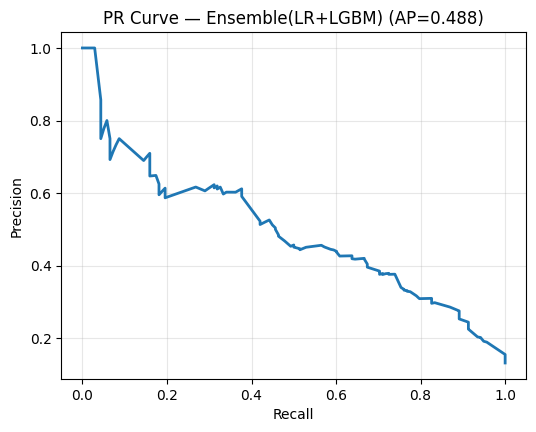

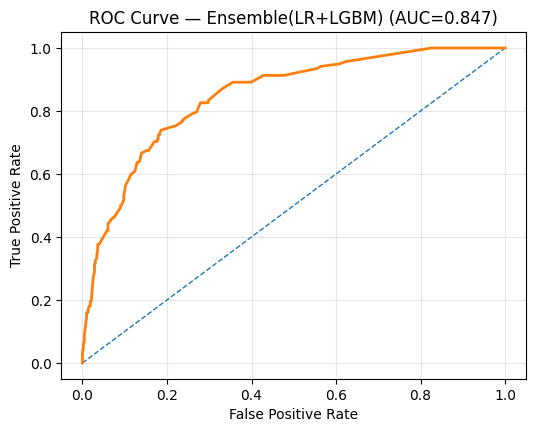

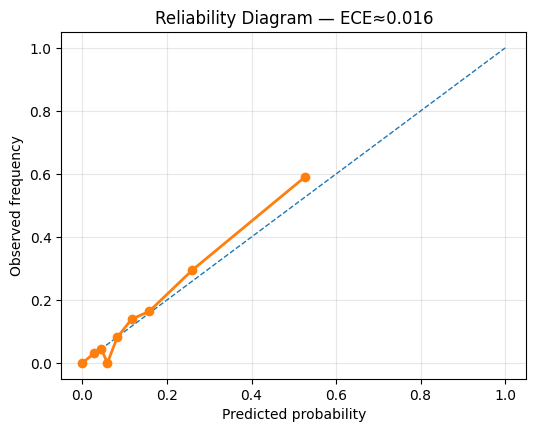

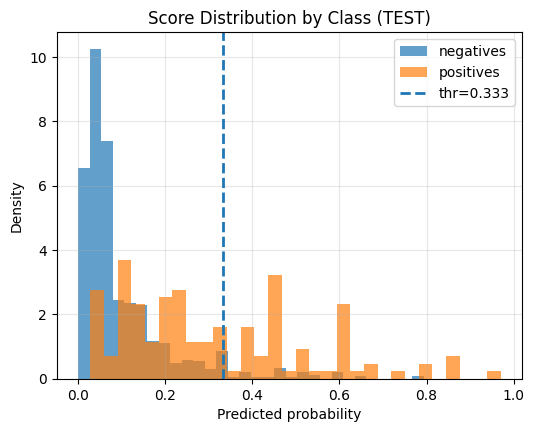

,n,avg_pred,emp_rate
0,350,0.015429,0.017143
1,138,0.045148,0.043478
2,38,0.059005,0.000000
3,136,0.082256,0.080882
4,72,0.116164,0.138889
5,104,0.157672,0.163462
6,122,0.260173,0.295082
7,88,0.526888,0.590909



Classification report @ chosen threshold:
              precision    recall  f1-score   support

           0      0.915     0.942     0.928       910
           1      0.523     0.420     0.466       138

    accuracy                          0.873      1048
   macro avg      0.719     0.681     0.697      1048
weighted avg      0.863     0.873     0.867      1048


=== Basic Analysis (TEST) ===
Base rate (positives): 0.132
PR-AUC (AP):           0.488
ROC-AUC:               0.847
Brier score:           0.087  (lower is better)
ECE (10 bins):         0.016  (lower is better)

Operating point (validation top 10% threshold = 0.333):
 Flagging rate (TEST): 0.106
 Precision:            0.523
 Recall:               0.420
 Specificity:          0.942
 Accuracy:             0.873
 F1 score:             0.466
 Lift vs. base:        3.97x


In [ ]:
# ===== 19) INLINE DIAGNOSTICS + BASIC ANALYSIS =====

y_true = np.asarray(y_test).astype(int)
p_pred = np.asarray(p_test_final, dtype=float)

# scalar metrics (TEST) 
ap  = float(average_precision_score(y_true, p_pred))   
auc = float(roc_auc_score(y_true, p_pred))             
brier = float(brier_score_loss(y_true, p_pred))
base = float(y_true.mean())

# thresholded metrics using validation-picked thr
y_hat = (p_pred >= thr).astype(int)
tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
prec = tp / (tp + fp) if (tp + fp) else 0.0
rec  = tp / (tp + fn) if (tp + fn) else 0.0
spec = tn / (tn + fp) if (tn + fp) else 0.0
acc  = (tp + tn) / (tn + fp + fn + tp)
f1   = (2*prec*rec)/(prec+rec) if (prec+rec) else 0.0
flag_rate = float(y_hat.mean())
lift = (prec / base) if base > 0 else float('nan')

#  PR curve & ROC curve 
prec_curve, rec_curve, _ = precision_recall_curve(y_true, p_pred)
fpr, tpr, _ = roc_curve(y_true, p_pred)

plt.figure(figsize=(6,4.5))
plt.plot(rec_curve, prec_curve, linewidth=2)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"PR Curve — {overall_winner} (AP={ap:.3f})")
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(6,4.5))
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.plot(fpr, tpr, linewidth=2)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve — {overall_winner} (AUC={auc:.3f})")
plt.grid(alpha=0.3)
plt.show()

#  reliability (calibration) diagram 
prob_true, prob_pred = calibration_curve(y_true, p_pred, n_bins=10, strategy='quantile')
plt.figure(figsize=(6,4.5))
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.plot(prob_pred, prob_true, marker='o', linewidth=2)
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title(f"Reliability Diagram — ECE≈{test_ece10:.3f}")
plt.grid(alpha=0.3)
plt.show()

#  score histograms by class (how well it separates) 
plt.figure(figsize=(6,4.5))
plt.hist(p_pred[y_true==0], bins=30, alpha=0.7, label="negatives", density=True)
plt.hist(p_pred[y_true==1], bins=30, alpha=0.7, label="positives", density=True)
plt.axvline(thr, linestyle='--', linewidth=2, label=f"thr={thr:.3f}")
plt.xlabel("Predicted probability"); plt.ylabel("Density")
plt.title("Score Distribution by Class (TEST)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# reliability table (10-bin) 
import pandas as pd
bin_df = pd.DataFrame({"pred": p_pred, "y": y_true})
q = pd.qcut(bin_df["pred"], q=10, duplicates='drop')
rel_tbl = bin_df.groupby(q, observed=True).agg(
    n=("y","size"),
    avg_pred=("pred","mean"),
    emp_rate=("y","mean")
).reset_index(drop=True)
display(rel_tbl)

#  classification report at chosen threshold 
print("\nClassification report @ chosen threshold:")
print(classification_report(y_true, y_hat, digits=3))

#  concise analysis summary 
print("\n=== Basic Analysis (TEST) ===")
print(f"Base rate (positives): {base:.3f}")
print(f"PR-AUC (AP):           {ap:.3f}")
print(f"ROC-AUC:               {auc:.3f}")
print(f"Brier score:           {brier:.3f}  (lower is better)")
print(f"ECE (10 bins):         {test_ece10:.3f}  (lower is better)")
print(f"\nOperating point (validation top {int(TOP_FRAC*100)}% threshold = {thr:.3f}):")
print(f" Flagging rate (TEST): {flag_rate:.3f}")
print(f" Precision:            {prec:.3f}")
print(f" Recall:               {rec:.3f}")
print(f" Specificity:          {spec:.3f}")
print(f" Accuracy:             {acc:.3f}")
print(f" F1 score:             {f1:.3f}")
print(f" Lift vs. base:        {lift:.2f}x")
